<a href="https://colab.research.google.com/github/ashok-arora/heart-attack-predictor/blob/main/zoomcamp_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Attack Predictor

**Dataset**: https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

**Link to repository**: https://github.com/ashok-arora/heart-attack-predictor

Note: The README.md inside the repository containes the problem statement and the detailed description of the approach.  


## This notebook has been organized in the form of:

code snippet

---

followed by the inference from the output of the code snippet. 

## Importing the necessary libraries

In [ ]:
import glob
import os

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load Data


In [ ]:
df = pd.read_csv('./heart.csv')

In [ ]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

The column names contain no spaces and are all lowercase and hence correctly formatted. 

Next, dropping the non-useful columns: track, artist and uri.  





In [ ]:
print("The shape of the dataset is : ", df.shape)

The shape of the dataset is :  (303, 14)


In [ ]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [ ]:
print(f'The dataset consists of {len(df)} rows.')

The dataset consists of 303 rows.


In [ ]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

Let's seperate the columns into categorical and numerical on the basis of their value counts.

In [ ]:
d = {}
cat_cols = []
num_cols = []
target_col = []
for i in list(df.columns):
    d[i] = df[i].value_counts().shape[0]
    
    if i == "output":
      target_col.append(i)

    elif df[i].value_counts().shape[0] < 10:
      cat_cols.append(i)
    else:
      num_cols.append(i)
pd.DataFrame(d,index=["unique count"]).transpose()

,unique count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


In [ ]:
print("The categorial cols are : ", cat_cols)
print("The continuous cols are : ", num_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


## Exploratory Data Analysis (EDA)

In [ ]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

**No missing values** were found for any of the columns in the dataset and hence there is no need to fill them with mean or median.

In [ ]:
df.output.value_counts(normalize=True)

1    0.544554
0    0.455446
Name: output, dtype: float64

The ratio of values in each class is **almost equal**, this highlights that there is **no class imbalance** and thus the classifier will not be biased towards a particular class.

---

Incase of class imbalance, Synthetic Minority Oversampling Technique (SMOTE) is used to fix it.  

In [ ]:
df[num_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


From the description above, it can be inferred that the dataset considers patients of age between 29 and 77 which is a good inclusion of different age groups.

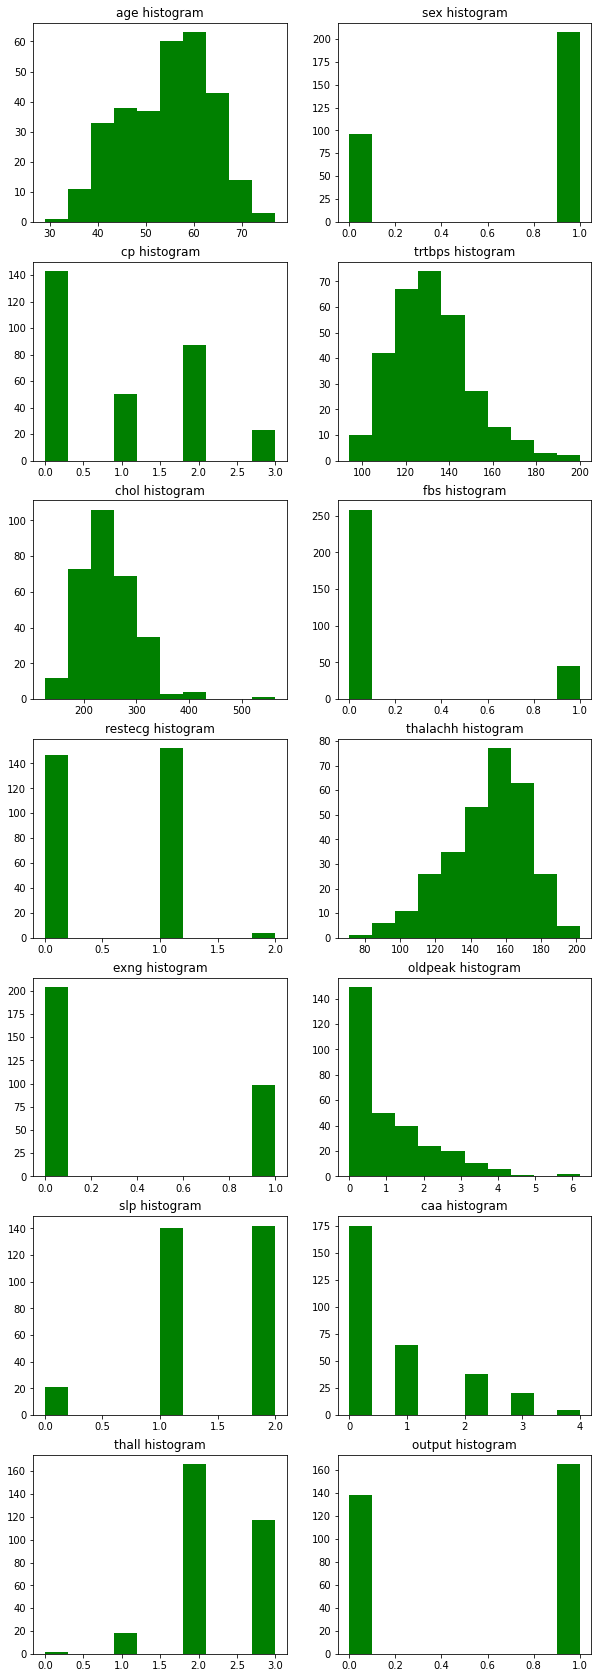

In [ ]:
#create histograpms of all the variables to see distributions
fig, ax = plt.subplots(7,2, figsize=(10,30))

def hist_plot(row=0, column=0, variable=None, binsnum=10, color='g'):
    ax[row, column].hist(df[variable], bins = binsnum, color = color)
    ax[row, column].set_title(variable + ' histogram')

idx = 0
for i in range(0, 7):
  for j in range(0, 2):
      hist_plot(i, j, df.columns[idx])
      idx += 1 

In [ ]:
pearson_corr = df.drop('output', axis=1).corr(method='pearson')
pearson_corr

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244


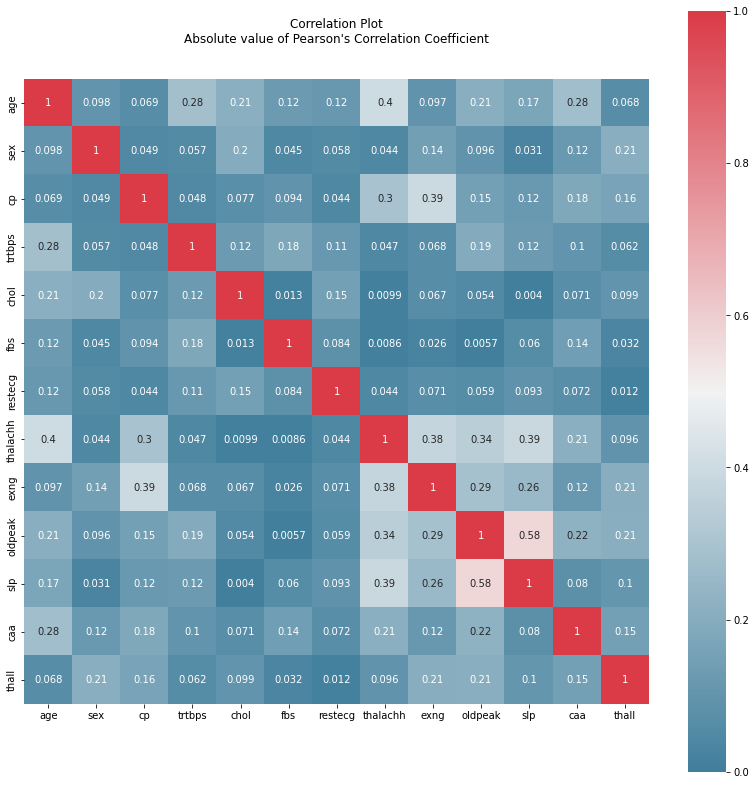

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))

plt.title("Correlation Plot\nAbsolute value of Pearson's Correlation Coefficient\n\n")
sns.heatmap(pearson_corr.abs(),
            cmap=sns.diverging_palette(230, 10, as_cmap=True),
            square=True,
            vmin=0,
            vmax=1,
            ax=ax,
            annot=True)
plt.show()

In [ ]:
spearman_corr = df.drop('output', axis=1).corr(method='spearman')
spearman_corr

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
age,1.000000,-0.099131,-0.087494,0.285617,0.195786,0.113978,-0.132769,-0.398052,0.089679,0.268291,-0.184048,0.340955,0.087254
sex,-0.099131,1.000000,-0.062041,-0.052941,-0.151342,0.045032,-0.048389,-0.039868,0.141664,0.100715,-0.025010,0.119368,0.250821
cp,-0.087494,-0.062041,1.000000,0.035413,-0.091721,0.089775,0.065640,0.324013,-0.418256,-0.161449,0.159478,-0.216006,-0.207840
trtbps,0.285617,-0.052941,0.035413,1.000000,0.126562,0.151984,-0.125841,-0.040407,0.052918,0.154267,-0.086570,0.090140,0.059673
chol,0.195786,-0.151342,-0.091721,0.126562,1.000000,0.018463,-0.161933,-0.046766,0.091514,0.045260,-0.012551,0.111981,0.083628
fbs,0.113978,0.045032,0.089775,0.151984,0.018463,1.000000,-0.081508,-0.014273,0.025665,0.028363,-0.045786,0.134513,-0.006737
restecg,-0.132769,-0.048389,0.065640,-0.125841,-0.161933,-0.081508,1.000000,0.087863,-0.077399,-0.077372,0.113661,-0.097862,-0.010982
thalachh,-0.398052,-0.039868,0.324013,-0.040407,-0.046766,-0.014273,0.087863,1.000000,-0.400860,-0.433241,0.436968,-0.257347,-0.160581
exng,0.089679,0.141664,-0.418256,0.052918,0.091514,0.025665,-0.077399,-0.400860,1.000000,0.297173,-0.274475,0.162025,0.247113
oldpeak,0.268291,0.100715,-0.161449,0.154267,0.045260,0.028363,-0.077372,-0.433241,0.297173,1.000000,-0.594847,0.224895,0.255026


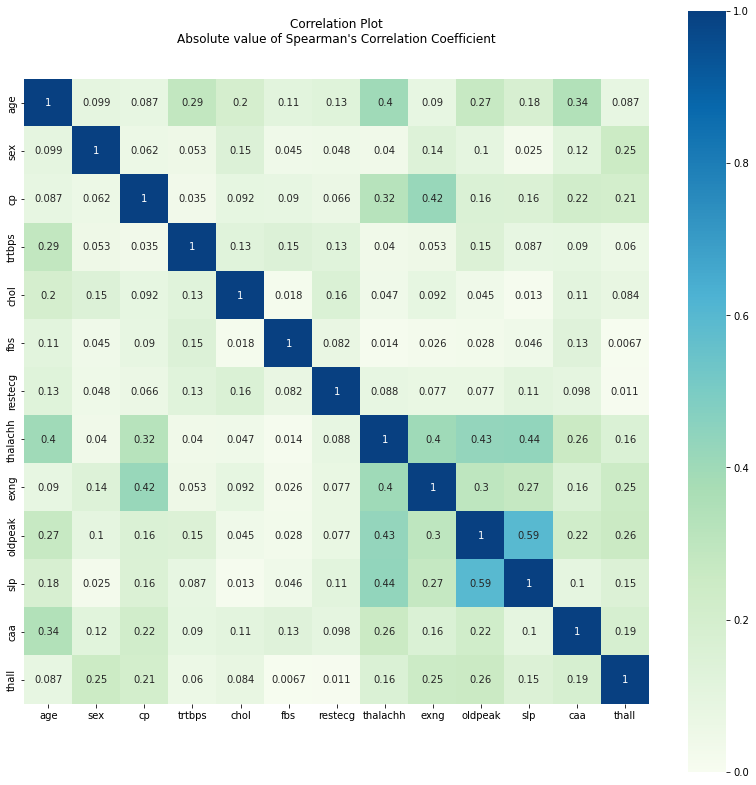

In [ ]:
fig, ax = plt.subplots(figsize=(14, 14))

plt.title("Correlation Plot\nAbsolute value of Spearman's Correlation Coefficient\n\n")
sns.heatmap(spearman_corr.abs(),
            cmap='GnBu',
            square=True,
            vmin=0,
            vmax=1,
            ax=ax,
            annot=True)
plt.show()

In [ ]:
from sklearn.feature_selection import f_classif
anova_f_values = f_classif(df.drop(['output'], axis=1), df['output'])[0]

linear_corr = pd.Series(anova_f_values, index=df.drop(['output'], axis=1).columns)
linear_corr.sort_values(ascending=False)

exng        70.952438
cp          69.772271
oldpeak     68.551439
thalachh    65.120104
caa         54.559834
slp         40.902071
thall       40.407696
sex         25.792191
age         16.116700
trtbps       6.458169
restecg      5.777209
chol         2.202983
fbs          0.236942
dtype: float64

Since the correlation values between any two variables is not greater than 90%, none of the attributes were removed.

## Model Training & Tuning


### Encoding categorical features 


In [ ]:
df1 = df

In [ ]:
# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

In [ ]:
# defining the features and target
X = df1.drop(['output'],axis=1)
y = df1[['output']]

In [ ]:
from sklearn.preprocessing import RobustScaler
# instantiating the scaler
scaler = RobustScaler()

# scaling the numerical features
X[num_cols] = scaler.fit_transform(X[num_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,0.592593,0.75,-0.110236,-0.092308,0.9375,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.333333,0.00,0.157480,1.046154,1.6875,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,-1.037037,0.00,-0.566929,0.584615,0.3750,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0.074074,-0.50,-0.062992,0.769231,0.0000,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,0.148148,-0.50,1.795276,0.307692,-0.1250,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
df.shape

(303, 14)

In [ ]:
df1.shape

(303, 23)

### Splitting entire dataset into train/val/test ratio of 80/20/20 %

In [ ]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=11)
print(len(df), len(X_full_train), len(X_train), len(X_val), len(X_test))

303 242 181 61 61


In [ ]:
X_val

,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
112,0.666667,0.50,1.149606,-0.615385,-0.3750,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1
179,0.148148,1.00,0.566929,-1.261538,-0.1250,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0
0,0.592593,0.75,-0.110236,-0.092308,0.9375,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
50,-0.296296,0.00,0.251969,-0.123077,-0.1875,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
231,0.148148,1.75,0.771654,-0.892308,0.1250,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.518519,1.50,-1.196850,-0.246154,3.3750,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
90,-0.518519,-0.30,0.236220,0.676923,-0.5000,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0
104,-0.370370,-0.05,-0.692913,0.307692,-0.5000,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
261,-0.222222,-0.90,-0.157480,0.215385,-0.5000,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression(solver='lbfgs', random_state=11)
model.fit(X_train, y_train)

LogisticRegression(random_state=11)

In [ ]:
model

LogisticRegression(random_state=11)

In [ ]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 11,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9095860566448801

In [ ]:
y_pred = model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.958914159941306

The untuned LR model has an accuracy of 90.95% on the validation dataset.

In [ ]:
param_grid = {
              'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear', 'lbfgs', 'newton-cg'],
              'tol': np.logspace(-4, 4, 20)
              }

In [ ]:
grid_search = GridSearchCV(LogisticRegression(random_state=11), param_grid=param_grid, cv=10, verbose=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 4800 candidates, totalling 48000 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=11), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+...
                         'solver': ['liblinear', 'lbfgs', 'newton-cg'],
                         'tol': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             verbose=True)

In [ ]:
final_model = grid_search.best_estimator_
final_model

LogisticRegression(C=0.0001, penalty='none', random_state=11,
                   tol=0.012742749857031334)

In [ ]:
y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8954248366013072

In [ ]:
y_pred = final_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9678405478112009

Using a grid search with 10 fold cross validation wasn't much helpful in increasing the accuracy. Let's instead try to use randomized search to improve the accuracy.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomizedSearchCV(model, param_grid, random_state=11, cv=10)

search = clf.fit(X_train, y_train)
final_model = search.best_estimator_

y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9106753812636166

In [ ]:
search.best_params_

{'C': 0.0006951927961775605,
 'penalty': 'none',
 'solver': 'lbfgs',
 'tol': 0.23357214690901212}

Using RandomizedSearchCV with 10 fold cross validation improved the accuracy to 91.06% from 90.95%.

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_text

In [ ]:
dt = DecisionTreeClassifier(random_state=11)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=11)

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7156862745098039

In [ ]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [ ]:
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 11,
 'splitter': 'best'}

The untuned decision tree model has an accuracy of 71.56% on the validation dataset.

In [ ]:
param_grid = {
              'criterion' :['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth' : [10, 20, 50, 100, 200, 500],
              'min_samples_leaf': [1, 5, 10, 15, 20, 50],
              'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
             }

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=11), param_grid=param_grid, verbose=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=11), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 50, 100, 200, 500],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 50],
                         'splitter': ['best', 'random']},
             verbose=True)

In [ ]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=10, max_features='auto',
                       min_samples_leaf=5, random_state=11, splitter='random')

In [ ]:
y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8071895424836601

In [ ]:
y_pred = final_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7985448764979213

Using a grid search with 10 fold cross validation helped in finding the right hyperparamaters to boost the accuracy to 80.71%.

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=11)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=11)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8823529411764707

In [ ]:
y_pred = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9999999999999999

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 11,
 'verbose': 0,
 'warm_start': False}

The untuned random forest has an accuracy of 86.94% on the validation dataset.

In [ ]:
param_grid = {
              'n_estimators' :[100, 110, 120, 130, 140, 150, 200],
              'max_depth' : [5, 10, 15, 50],
              'min_samples_leaf': [1, 3, 5, 10, 20],
             }

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=11), param_grid=param_grid, cv=2, verbose=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 140 candidates, totalling 280 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=11), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 50],
                         'min_samples_leaf': [1, 3, 5, 10, 20],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 200]},
             verbose=True)

In [ ]:
final_model = grid_search.best_estimator_
final_model

RandomForestClassifier(max_depth=5, n_estimators=130, random_state=11)

In [ ]:
final_model.fit(X_train, y_train)
y_pred = final_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8790849673202614

In [ ]:
y_pred = final_model.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.9924186842748838

Using a grid search did not boost the accuracy, this could be because the param_grid supplied to the search wasn't good enough so I'll try to find the best values for the following parameters manually: 
  
  * n_estimators
  * max_depth
  * min_samples_leaf

For n_estimators, I chose [10, 130] as the initial range.

In [ ]:
scores = []

for n in range(10, 131, 10):
  rf = RandomForestClassifier(n_estimators=n, random_state=11, n_jobs=-1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict_proba(X_val)[:, 1]
  score = roc_auc_score(y_val, y_pred)
  scores.append((n, score))

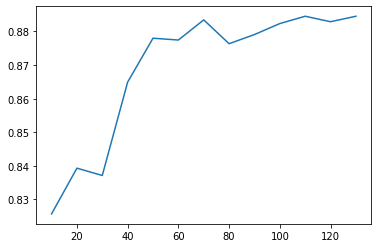

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)

but the accuracy kept increasing, so I increased the range to [10, 1000] to find a stagnation in accuracy value.

In [ ]:
scores = []

for n in range(10, 1001, 100):
  rf = RandomForestClassifier(n_estimators=n, random_state=11, n_jobs=-1)
  rf.fit(X_train, y_train)

  y_pred = rf.predict_proba(X_val)[:, 1]
  score = roc_auc_score(y_val, y_pred)
  scores.append((n, score))

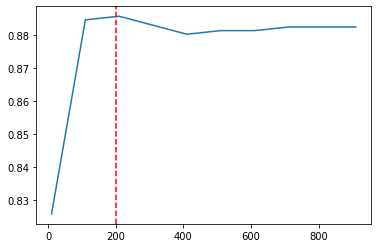

In [ ]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.axvline(200, color='red', linestyle='--')

The accuracy seems to stagnate around n=200 at about 88.x%. 

In [ ]:
scores = []

for d in range(1, 200, 15):
    for n in range(10, 201, 100):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=11, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [ ]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

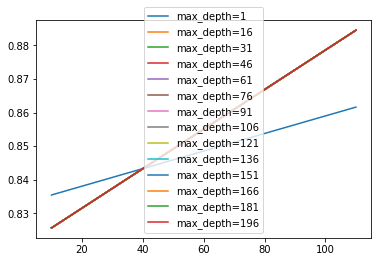

In [ ]:
for d in range(1, 200, 15):
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [ ]:
for d in range(1, 200, 15):
  print('{} {}'.format(d, df_scores[df_scores.max_depth == d].auc.max()))

1 0.8616557734204793
16 0.8845315904139434
31 0.8845315904139434
46 0.8845315904139434
61 0.8845315904139434
76 0.8845315904139434
91 0.8845315904139434
106 0.8845315904139434
121 0.8845315904139434
136 0.8845315904139434
151 0.8845315904139434
166 0.8845315904139434
181 0.8845315904139434
196 0.8845315904139434


The best value of max_depth is 16. 

The aim is to maximize accuracy but also minimize max_depth value since then it will consume less time and computational power.

In [ ]:
max_depth = 16

In [ ]:
scores = []

for s in range(1, 51, 10): # [1, 3, 5, 10, 50]:
    for n in range(10, 201, 100):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=11, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

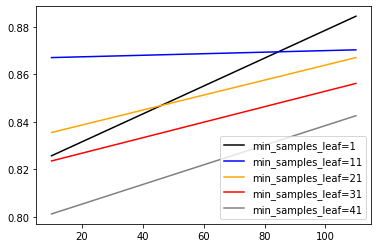

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = range(1, 51, 10) # [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

The value of min_samples_leaf = 1 gives the best accuracy on the validation dataset.

Hence, the final parameter values are:
 * n_estimators=200,
 * max_depth=16,
 * min_samples_leaf=1

In [ ]:
min_samples_leaf = 1

In [ ]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=16,
                            min_samples_leaf=1,
                            random_state=11, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=200, n_jobs=-1,
                       random_state=11)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8856209150326798

In [ ]:
y_pred = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Tuning the hyperparamaters boosted the accuracy of random forest from 88.2% to 88.56% on the validation dataset.

### XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# features = dv.get_feature_names()
features = X_train.columns
# features
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 60,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [ ]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-auc:0.970653	val-auc:0.821351
[5]	train-auc:0.996882	val-auc:0.866013
[10]	train-auc:1	val-auc:0.863834
[15]	train-auc:1	val-auc:0.866013
[20]	train-auc:1	val-auc:0.866013
[25]	train-auc:1	val-auc:0.87146
[30]	train-auc:1	val-auc:0.87037
[35]	train-auc:1	val-auc:0.873638
[40]	train-auc:1	val-auc:0.877996
[45]	train-auc:1	val-auc:0.880174
[50]	train-auc:1	val-auc:0.875817
[55]	train-auc:1	val-auc:0.868192
[60]	train-auc:1	val-auc:0.868192
[65]	train-auc:1	val-auc:0.867102
[70]	train-auc:1	val-auc:0.867102
[75]	train-auc:1	val-auc:0.864924
[80]	train-auc:1	val-auc:0.863834
[85]	train-auc:1	val-auc:0.859477
[90]	train-auc:1	val-auc:0.859477
[95]	train-auc:1	val-auc:0.862745
[100]	train-auc:1	val-auc:0.858388
[105]	train-auc:1	val-auc:0.857298
[110]	train-auc:1	val-auc:0.857298
[115]	train-auc:1	val-auc:0.858388
[120]	train-auc:1	val-auc:0.856209
[125]	train-auc:1	val-auc:0.85512
[130]	train-auc:1	val-auc:0.856209
[135]	train-auc:1	val-auc:0.858388
[140]	train-auc:1	val-auc:0.857

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8572984749455337

In [ ]:
y_pred = model.predict(dtrain)
roc_auc_score(y_train, y_pred)

1.0

The untuned XG Boost model has an accuracy of 85.72% on the validation dataset. 

Using grid search on XG Boost was very time-consuming so I am going to manually tune the following hyperparameters by plotting them and picking the best:

* eta
* max_depth
* min_child_weight

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
etas = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.4, 
    'max_depth': 100,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'eta=%s' % (xgb_params['eta'])
etas[key] = parse_xgb_output(output)
key

'eta=0.4'

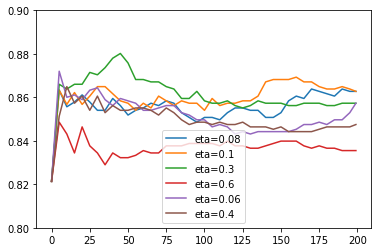

In [ ]:
for eta, df_score in etas.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.ylim(0.8, 0.9)
plt.legend()

From the plot, it is clear that eta=0.3 gives the best accuracy. 

In [ ]:
scores = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

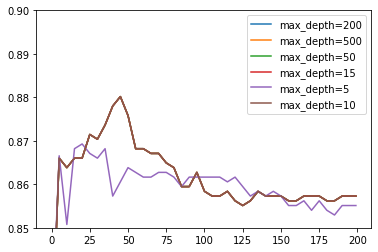

In [ ]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.85, 0.9)
plt.legend()

max_depth=15 and max_depth=100 have overlapping plots, since lower value of max_depth saves time and computational power, max_depth=15 is selected.

In [ ]:
weights = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 15,
    'min_child_weight': 3,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
weights[key] = parse_xgb_output(output)
key

'min_child_weight=3'

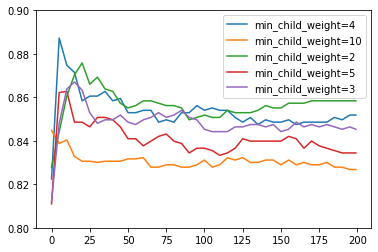

In [ ]:
for min_child_weight, df_score in weights.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.8, 0.9)
plt.legend()

From the plot, it is clear the min_child_weight=4 gives the best accuracy on validation dataset.

In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 15,
    'min_child_weight': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=7,
                  verbose_eval=1,
                  evals=watchlist)

[0]	train-auc:0.889949	val-auc:0.82244
[1]	train-auc:0.900587	val-auc:0.845861
[2]	train-auc:0.92327	val-auc:0.87146
[3]	train-auc:0.942651	val-auc:0.860022
[4]	train-auc:0.945586	val-auc:0.87146
[5]	train-auc:0.963194	val-auc:0.887255
[6]	train-auc:0.969736	val-auc:0.893791


In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8937908496732027

Tuning the hyperparameters manually boosted the accuracy from 85.72% to 89.37% on the validation dataset.

## Selecting the best model

### Logistic Regression

In [ ]:
lr = LogisticRegression(C=0.0006951927961775605,
 penalty='none',
 solver='lbfgs',
 tol=0.23357214690901212,
 random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.0006951927961775605, penalty='none', random_state=42,
                   tol=0.23357214690901212)

In [ ]:
y_pred = lr.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9106753812636166

### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(ccp_alpha=0.01, max_depth=10, max_features='auto',
                       min_samples_leaf=5, random_state=11, splitter='random')
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=10, max_features='auto',
                       min_samples_leaf=5, random_state=11, splitter='random')

In [ ]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8071895424836601

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=16,
                            min_samples_leaf=1,
                            random_state=11, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=200, n_jobs=-1,
                       random_state=11)

In [ ]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8856209150326798

### XG Boost


In [ ]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 15,
    'min_child_weight': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=7) # ,evals=watchlist)

In [ ]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8937908496732027

The best performing model is XG Boost with an accuracy of 87.30% on the validation dataset, it will be exported to a Pickle file to be used with the Flask application. 

## Store best model as Pickle file

In [ ]:
y_pred = lr.predict_proba(X_full_train)[:, 1]
roc_auc_score(y_full_train, y_pred)

0.9523026315789473

The accuracy on the full_train dataset is 95.23% which is close to the validation dataset accuracy. 

In [ ]:
import pickle

In [ ]:
output_file = 'final_model_lr.bin'

f_out = open(output_file, 'wb') 
pickle.dump(lr, f_out)
f_out.close()

In [ ]:
!ls -lh *.bin

-rw-r--r-- 1 root root 1.4K Jan 26 08:05 final_model_lr.bin


In [ ]:
with open(output_file, 'wb') as f_out: 
    pickle.dump(lr, f_out)

## Load best model using

In [ ]:
input_file = 'final_model_lr.bin'

In [ ]:
with open(input_file, 'rb') as f_in: 
    model = pickle.load(f_in)

In [ ]:
patient = df.iloc[[0]]
patient

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1


In [ ]:
df11 = df.append(patient).reset_index(drop=True)

In [ ]:
# encoding the categorical columns
df11 = pd.get_dummies(df11, columns = cat_cols, drop_first = True)
df11

,age,trtbps,chol,thalachh,oldpeak,output,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,63,145,233,150,2.3,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,45,110,264,132,1.2,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
300,68,144,193,141,3.4,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1
301,57,130,131,115,1.2,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1
302,57,130,236,174,0.0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


In [ ]:
# defining the features and target
X = df11.drop(['output'],axis=1)
y = df11[['output']]

In [ ]:
X

,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,63,145,233,150,2.3,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,57,120,354,163,0.6,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,45,110,264,132,1.2,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
300,68,144,193,141,3.4,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1
301,57,130,131,115,1.2,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,1
302,57,130,236,174,0.0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


In [ ]:
from sklearn.preprocessing import RobustScaler
# instantiating the scaler
scaler = RobustScaler()

# scaling the numerical features
X[num_cols] = scaler.fit_transform(X[num_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,0.566038,0.75,-0.110672,-0.077519,0.9375,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0
1,-1.396226,0.00,0.158103,1.069767,1.6875,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,-1.094340,0.00,-0.569170,0.604651,0.3750,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0.037736,-0.50,-0.063241,0.790698,0.0000,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
4,0.113208,-0.50,1.802372,0.325581,-0.1250,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0


In [ ]:
y_pred = lr.predict_proba(X)[:, 1]
y_pred[303]

0.9989797777561001

In [ ]:
y.iloc[303]

output    1
Name: 303, dtype: int64

In [ ]:
roc_auc_score(y, y_pred)

0.9371398638030383

In [ ]:
for i in range(5):
    print(df.iloc[i].to_json("row{}.json".format(i)))

None
None
None
None
None


In [ ]:
 df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
